In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Specify the model to be used
COCO and MPI are body pose estimation model. COCO has 18 points and MPI has 15 points as output.

HAND is hand keypoints estimation model. It has 22 points as output

Ensure that the model files are available in the folders.

In [5]:
MODE = "COCO"

if MODE is "COCO":
    #protoFile = "pose/coco/pose_deploy_linevec.prototxt"
    protoFile = "pose_deploy_linevec.prototxt"
    #weightsFile = "pose/coco/pose_iter_440000.caffemodel"
    weightsFile = "pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]
    

#### Let us load an image with multiple people and check what the model sees

In [6]:
image1 = cv2.imread("content.jpg")
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]
threshold = 0.1

#### Load the network and pass the image through the network

In [7]:
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

inWidth = 368
inHeight = 368
inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
H = output.shape[2]
W = output.shape[3]
print(output.shape)

(1, 57, 46, 46)


#### Slice a probability map from the output for a specific keypoint and plot the heatmap ( after resizing ) on the image itself

(-0.5, 1279.5, 719.5, -0.5)

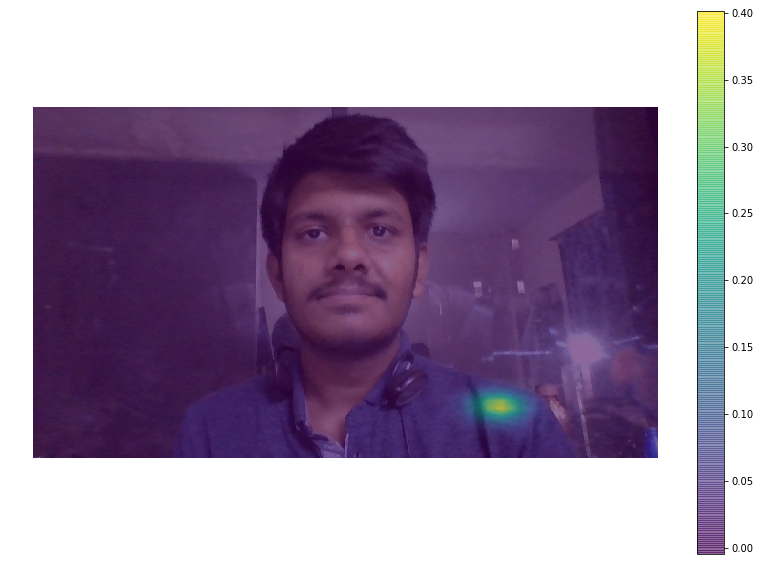

In [8]:
i = 5
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

#### Similarly plot the affinity map on the image

(-0.5, 1279.5, 719.5, -0.5)

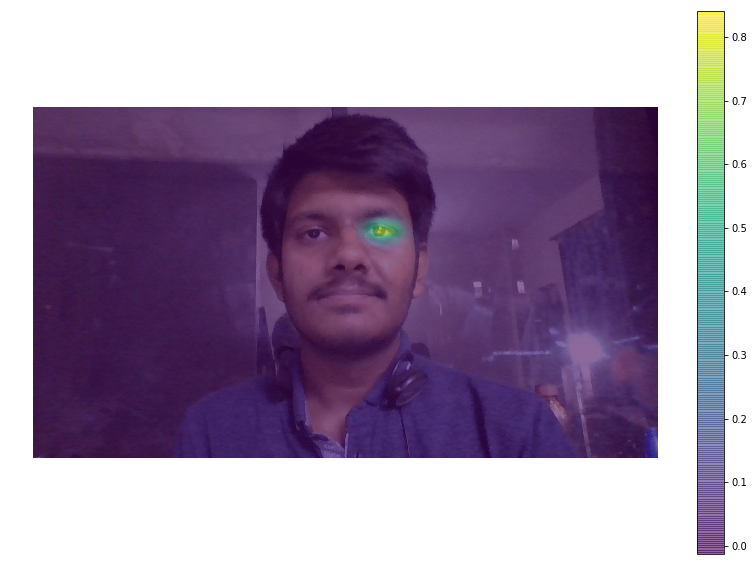

In [9]:
i = 15
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

#### Next, we find the keypoints for a image with only single person

In [13]:
frame = cv2.imread("content.jpg")
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1

#### Pass it through the network

In [14]:
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)

output = net.forward()
H = output.shape[2]
W = output.shape[3]

#### gather the points and plot the keypoints and the skeleton figure

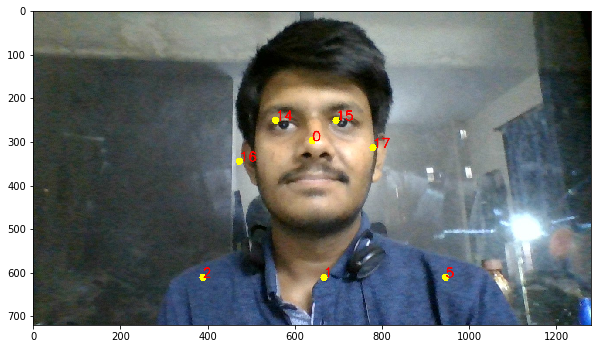

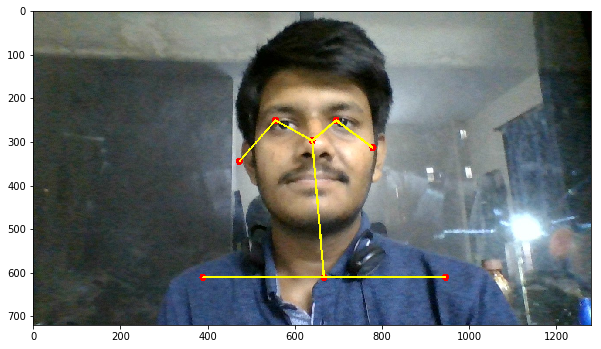

In [15]:
# Empty list to store the detected keypoints
points = []

for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image
    x = (frameWidth * point[0]) / W
    y = (frameHeight * point[1]) / H

    if prob > threshold : 
        cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

# Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)

plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))